<h1 id="tocheading">Finding Patterns in Data using IBM Power and PowerAI</h1>
<div id="toc"></div>

In this lab we will explore an open source data set, and discover how we can use the tools that are part of **PowerAI** to explore and discover patterns in the data.  For this lab, we will make use of the Lending Club data set, **scikit learn, Tensorflow and Keras**.  Here is a brief description about Lending Club.

```
About the author's
Dustin VanStee - Data Scientist
Bob Chesebrough - Data Scientist
IBM Systems AI Center of Competence
contact : vanstee@us.ibm.com
```


<img src="https://github.com/dustinvanstee/random-public-files/raw/master/techu-banner.png" width="800" height="500" align="middle"/>

[Lending Club (LC)](https://www.lendingclub.com/) is the world’s largest online marketplace connecting borrowers and investors. It is transforming the banking system to make credit more affordable and investing more rewarding. Lending Club operates at a lower cost than traditional bank lending programs and pass the savings on to borrowers in the form of lower rates and to investors in the form of solid risk-adjusted returns.

**The DATA**  
The original data set is downloaded from [LC](https://www.lendingclub.com/info/download-data.action) covering complete loan data for all loans issued through the 2007-2018, including the current loan status (Current, Late, Fully Paid, etc.) and latest payment information. Additional features include credit history, number of finance inquiries, address including zip codes, and state, and collections among others. It is quite rich and is an excellent example of credit risk data.  Interestingly, Goldman Sachs’ new peer-to-peer lending platform called Marcus was built almost entirely using the Lending Club data.

Here is a link to some extra information regarding the fields of the data set.
[Data Dictionary](https://github.com/dustinvanstee/mldl-101/blob/master/lab5-powerai-lc/LCDataDictionary.csv)

**Important**

In this notebook, we will play with the lending club data, conduct a set of exploratory analysis and try to apply various machine learning techniques to predict borrower’s default. We took a small sample of loans made in 2016 (130K) to help speed up the processing time for the lab


Note : to remove a lot of the busy verbose code, we are making using of a utility python file called lc_utils.py.  For implemenation details you can refer here [python code](https://github.com/dustinvanstee/mldl-101/blob/master/lab5-powerai-lc/lc_utils.py)

### Quick word on the data science method
<img src="https://github.com/dustinvanstee/random-public-files/raw/master/dsx-methodology.png" width="900" height="700" align="middle"/>

Here we will use these simple high level steps to work through a typical data science problem.  This workflow is meant to be a high level guide, but in practice this is a highly iterative approach ...

### Goals

* Perform some initial analysis of the data for **Business Understanding**
* **Prepare the Data** for our visualization and modeling
* **Visualize** the data
* Model using **Dimension Reduction** and **Classification** techniques
* **Evaluate** the approach

## Business/Data Understanding and Preparation
<img src="https://github.com/dustinvanstee/random-public-files/raw/master/techu-bu-dp.png" width="800" height="500" align="middle"/>

### Environment bootstrapping
Run the following commands to install a few python packages for later use

In [ ]:
# !pip install -q jupyter-pip
# !pip install -q brunel
# import brunel
# !git fetch origin master
# !git reset --hard origin/master

### Import Libraries

In [1]:
# Code functions that are needed to run this lab
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import time
from datetime import datetime
import math

import pandas as pd
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import glob

# custom library for some helper functions 
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import myenv as myenv
import brunel

In [2]:
import sys
sys.path.append("../utils") # go to parent dir

%load_ext autoreload
%autoreload 2
from lc_utils_2020 import *

### Load the Data
Here we load data that was previously downloaded from lendingclub.com.  For speed of this lab, we are restricting the number of loans ~ 130K

In [31]:
loan_df = load_sample_data('acc')
loan_df_orig = loan_df.copy()
loan_df.head()

**load_sample_data** : Setting data location to /gpfs/home/s4s004/vanstee/2019-06-lendingclub-git/rawdata/
**load_sample_data** : Found 13 files.  CSV files = ['/gpfs/home/s4s004/vanstee/2019-06-lendingclub-git/rawdata/LoanStats_securev1_2018Q1.csv.gz', '/gpfs/home/s4s004/vanstee/2019-06-lendingclub-git/rawdata/LoanStats_securev1_2017Q3.csv.gz', '/gpfs/home/s4s004/vanstee/2019-06-lendingclub-git/rawdata/LoanStats_securev1_2019Q1.csv.gz', '/gpfs/home/s4s004/vanstee/2019-06-lendingclub-git/rawdata/LoanStats_securev1_2016Q2.csv.gz', '/gpfs/home/s4s004/vanstee/2019-06-lendingclub-git/rawdata/LoanStats_securev1_2018Q4.csv.gz', '/gpfs/home/s4s004/vanstee/2019-06-lendingclub-git/rawdata/LoanStats_securev1_2018Q2.csv.gz', '/gpfs/home/s4s004/vanstee/2019-06-lendingclub-git/rawdata/LoanStats_securev1_2018Q3.csv.gz', '/gpfs/home/s4s004/vanstee/2019-06-lendingclub-git/rawdata/LoanStats_securev1_2016Q3.csv.gz', '/gpfs/home/s4s004/vanstee/2019-06-lendingclub-git/rawdata/LoanStats_securev1_2017Q1.csv

,acc_now_delinq,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,application_type,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collection_recovery_fee,collections_12_mths_ex_med,debt_settlement_flag,debt_settlement_flag_date,deferral_term,delinq_2yrs,delinq_amnt,desc,disbursement_method,dti,dti_joint,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,funded_amnt,funded_amnt_inv,grade,hardship_amount,hardship_dpd,hardship_end_date,hardship_flag,hardship_last_payment_amount,hardship_length,hardship_loan_status,hardship_payoff_balance_amount,hardship_reason,hardship_start_date,hardship_status,hardship_type,home_ownership,id,il_util,initial_list_status,inq_fi,inq_last_12m,inq_last_6mths,installment,int_rate,issue_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,last_pymnt_amnt,last_pymnt_d,loan_amnt,loan_status,max_bal_bc,member_id,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_rcnt_il,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,next_pymnt_d,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,open_acc_6m,open_act_il,open_il_12m,open_il_24m,open_rv_12m,open_rv_24m,orig_projected_additional_accrued_interest,out_prncp,out_prncp_inv,payment_plan_start_date,pct_tl_nvr_dlq,percent_bc_gt_75,policy_code,pub_rec,pub_rec_bankruptcies,purpose,pymnt_plan,recoveries,revol_bal,revol_bal_joint,revol_util,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_earliest_cr_line,sec_app_fico_range_high,sec_app_fico_range_low,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_mths_since_last_major_derog,sec_app_num_rev_accts,sec_app_open_acc,sec_app_open_act_il,sec_app_revol_util,settlement_amount,settlement_date,settlement_percentage,settlement_status,settlement_term,sub_grade,tax_liens,term,title,tot_coll_amt,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bal_il,total_bc_limit,total_cu_tl,total_il_high_credit_limit,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,url,verification_status,verification_status_joint,zip_code
0,0.0,8.0,PA,52.0,53700.0,NaN,Individual,5713.0,20806.0,7.5,0.0,0.0,0.0,N,NaN,NaN,0.0,0.0,NaN,Cash,28.56,NaN,Nov-2001,10+ years,Facility manager,779.0,775.0,2500.0,2500.0,A,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MORTGAGE,130966408,85.0,w,3.0,4.0,3.0,76.87,6.71%,Mar-2018,Apr-2018,779.0,775.0,0.0,NaN,2500.0,Issued,1518.0,NaN,147.0,196.0,4.0,1.0,3.0,NaN,NaN,NaN,1.0,52.0,NaN,1.0,NaN,Apr-2018,0.0,2.0,6.0,4.0,8.0,20.0,10.0,15.0,6.0,20.0,0.0,0.0,0.0,5.0,20.0,4.0,8.0,4.0,6.0,1.0,2.0,NaN,2500.0,2500.0,NaN,100.0,0.0,1.0,0.0,0.0,other,n,0.0,8289.0,NaN,15.6%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A3,0.0,36 months,Other,0.0,114256.0,225791.0,38.0,58875.0,50586.0,22500.0,11.0,59491.0,0.0,0.0,0.0,0.0,0.0,53100.0,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,166xx
1,0.0,2.0,OR,61.0,40000.0,110000.0,Joint App,51837.0,15700.0,51.8,0.0,0.0,0.0,N,NaN,NaN,0.0,0.0,NaN,Cash,27.78,12.15,Mar-2003,6 years,Dental assistance/administration,729.0,725.0,25000.0,25000.0,C,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MORTGAGE,130846589,NaN,w,0.0,1.0,0.0,563.85,12.61%,Mar-2018,Mar-2018,729.0,725.0,0.0,NaN,25000.0,Issued,7471.0,NaN,125.0,180.0,19.0,19.0,2.0,NaN,NaN,NaN,57.0,24.0,NaN,11.0,NaN,Apr-2018,0.0,3.0,4.0,5.0,8.0,3.0,7.0,11.0,5.0,8.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,25000.0,25000.0,NaN,100.0,40.0,1.0,0.0,0.0,debt_consolidation,n,0.0,107401.0,35634.0,60.6%,0.0,0.0,Mar-2003,694.0,690.0,0.0,2.0,NaN,11.0,10.0,0.0,56.0,NaN,NaN,NaN,NaN,NaN,C1,0.0,60 months,Debt consolidation,0.0,414695.0,502520.0,16.0,107401.

#### Reload Data

In [200]:
# Samle the data to a reasonable number for debug
loan_df = loan_df_orig.copy()
loan_df =loan_df.sample(frac=0.10, replace=True, random_state=1)

### Descriptive Statistics (1D)
Lets look at some 1D and 2D descriptive statistics for this dataset

In this dataset, we have all types of data.  Numerical, Categorical, Ranked data.  This small module will take you through what is typical done to quickly understand the data



In [38]:
# This function provide the number of rows/cols
# Information on the types of data
# and a report of descriptive statistics

quick_overview_1d(loan_df)

**quick_overview_1d** : There are 148893 observations in the dataset.
**quick_overview_1d** : There are 151 variables in the dataset.
**quick_overview_1d** : 


**quick_overview_1d** : 
****************** Categorical vs Numerical  *****************************

**quick_overview_1d** : use df.dtypes ...
float64    111
object      40
Name: type, dtype: int64
**quick_overview_1d** : 


**quick_overview_1d** : 
****************** Cardinality Report  *****************************

addr_state 50 
application_type 2 
debt_settlement_flag 2 
debt_settlement_flag_date 18 
desc 3 
disbursement_method 2 
earliest_cr_line 656 
emp_length 11 
emp_title 47691 
grade 7 
hardship_end_date 18 
hardship_flag 2 
hardship_loan_status 4 
hardship_reason 9 
hardship_start_date 15 
hardship_status 3 
hardship_type 1 
home_ownership 5 
id 141624 
initial_list_status 2 
int_rate 250 
issue_d 39 
last_credit_pull_d 42 
last_pymnt_d 42 
loan_status 8 
next_pymnt_d 9 
payment_plan_start_date 16 
purpose 12 
pymnt

,acc_now_delinq,acc_open_past_24mths,all_util,annual_inc,annual_inc_joint,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collection_recovery_fee,collections_12_mths_ex_med,deferral_term,delinq_2yrs,delinq_amnt,dti,dti_joint,fico_range_high,fico_range_low,funded_amnt,funded_amnt_inv,hardship_amount,hardship_dpd,hardship_last_payment_amount,hardship_length,hardship_payoff_balance_amount,il_util,inq_fi,inq_last_12m,inq_last_6mths,installment,last_fico_range_high,last_fico_range_low,last_pymnt_amnt,loan_amnt,max_bal_bc,member_id,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_rcnt_il,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,open_acc_6m,open_act_il,open_il_12m,open_il_24m,open_rv_12m,open_rv_24m,orig_projected_additional_accrued_interest,out_prncp,out_prncp_inv,pct_tl_nvr_dlq,percent_bc_gt_75,policy_code,pub_rec,pub_rec_bankruptcies,recoveries,revol_bal,revol_bal_joint,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_fico_range_high,sec_app_fico_range_low,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_mths_since_last_major_derog,sec_app_num_rev_accts,sec_app_open_acc,sec_app_open_act_il,sec_app_revol_util,settlement_amount,settlement_percentage,settlement_term,tax_liens,tot_coll_amt,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bal_il,total_bc_limit,total_cu_tl,total_il_high_credit_limit,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim
count,148889.000000,148889.000000,148850.000000,1.488890e+05,1.358700e+04,148879.000000,146990.000000,146922.000000,148889.000000,148889.000000,148889.000000,382.0,148889.000000,148889.000000,148687.000000,13587.000000,148889.000000,148889.000000,148889.000000,148889.000000,382.000000,382.000000,382.000000,382.0,382.000000,127258.000000,148885.000000,148885.000000,148889.000000,148889.000000,148889.000000,148889.000000,148889.000000,148889.000000,148885.000000,0.0,144238.000000,148889.000000,148889.000000,148889.000000,148889.000000,71548.000000,38302.000000,23584.000000,144235.000000,147100.000000,33326.000000,131651.000000,48068.000000,148889.000000,148889.000000,148889.000000,148889.000000,148889.000000,148889.000000,148889.000000,148889.000000,148889.000000,148889.000000,142988.000000,148889.000000,148889.00000,148889.000000,148889.000000,148885.000000,148885.000000,148885.000000,148885.000000,148885.000000,148885.000000,320.000000,148889.000000,148889.000000,148888.000000,146985.000000,148889.0,148889.000000,148889.000000,148889.000000,1.488890e+05,12431.000000,12431.000000,12431.000000,12431.000000,12431.000000,12431.000000,12431.000000,4082.000000,12431.000000,12431.000000,12431.000000,12194.000000,266.000000,266.000000,266.000000,148889.000000,1.488890e+05,1.488890e+05,1.488890e+05,148889.000000,1.488890e+05,148885.000000,148889.000000,148885.000000,1.488890e+05,148889.000000,148889.000000,148889.000000,148889.000000,148889.000000,1.488890e+05
mean,0.003338,4.553063,56.846040,8.032434e+04,1.257243e+05,13789.823797,13094.096660,53.955479,0.008389,3.084606,0.019384,3.0,0.295515,11.967634,19.363339,19.282633,705.328728,701.328439,15315.168683,15310.729392,176.528613,9.185864,204.507042,3.0,13702.450026,69.066786,1.024952,2.023535,0.496974,453.099439,704.003466,697.938834,1749.514922,15315.168683,5846.035061,NaN,124.730335,179.120815,14.509514,8.367059,1.422147,34.956057,45.149104,74.167953,21.116262,24.918103,38.984006,7.176656,35.810622,0.505800,3.654676,5.524015,4.818650,7.301278,8.389250,8.201633,13.363432,5.463641,11.610569,0.000518,0.002284,0.07873,2.085923,11.646992,0.930430,2.776700,0.678168,1.56

Here we can get a quick assessment of the statistics for each column.  
**Quick Question** can you answer what was the average income for the 133K loan applicants ?

### Descriptive Statistics (2D)
Since we have over 100 numerical variables, creating a 2D correlation plot may be time consuming and difficult to interpret.  Lets look at correlations on a smaller scale for now....


**quick_overview_2d** : There are 148893 observations in the dataset.
**quick_overview_2d** : There are 151 variables in the dataset.


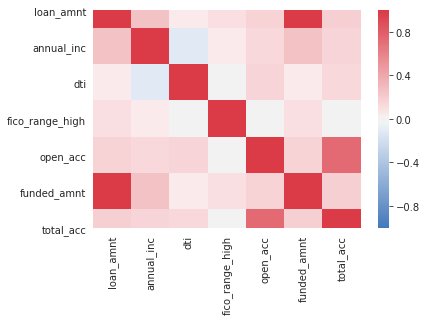

In [39]:
# Grab only a subset of columns
cols = ["loan_amnt","annual_inc","dti","fico_range_high","open_acc",'funded_amnt', 'total_acc']
quick_overview_2d(loan_df, cols)

**Quick Question** : Can you find a negatively correlated variable to annual_inc in the chart above?  Can you think of a reason for this result ?

## Data Preparation

### Create Loan Default column.  This is the column we will predict later
The **loan_status** column contains the information of whether or not the loan is in default. 

This column has more than just a 'default or paid' status.  Since our goal is to build a simple default classifier , we need to make a new column based off the **loan_status** column.

Here we will look at all the categorical values in **loan_status**, and create a new column called **default** based off that one.


In [201]:
# function to create loan status .... 
# Todo insert some extra 'noise' here ...
loan_df = create_loan_default(loan_df)
loan_df.head(3) # scroll to the right, and see the new 'default' column

**create_loan_default** : Unique values in loan_status
Current               121417
Fully Paid             17349
Charged Off             4044
Late (31-120 days)      2418
Issued                  1864
In Grace Period         1258
Late (16-30 days)        532
Default                    7
Name: loan_status, dtype: int64
29375
**create_loan_default** : Unique values in loan_status
Current               109214
Charged Off            29375
Fully Paid              7312
Late (31-120 days)      1250
Issued                   869
In Grace Period          598
Late (16-30 days)        270
Default                    1
Name: loan_status, dtype: int64
**create_loan_default** : Dropping other values that are highly correlated with loan_status
**create_loan_default** : Dropping loan_status,total_rec_prncp,total_pymnt,total_pymnt_inv
**create_loan_default** : Unique values in default
0    117997
1     30896
Name: default, dtype: int64


,acc_now_delinq,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,application_type,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collection_recovery_fee,collections_12_mths_ex_med,debt_settlement_flag,debt_settlement_flag_date,deferral_term,delinq_2yrs,delinq_amnt,desc,disbursement_method,dti,dti_joint,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,funded_amnt,funded_amnt_inv,grade,hardship_amount,hardship_dpd,hardship_end_date,hardship_flag,hardship_last_payment_amount,hardship_length,hardship_loan_status,hardship_payoff_balance_amount,hardship_reason,hardship_start_date,hardship_status,hardship_type,home_ownership,id,il_util,initial_list_status,inq_fi,inq_last_12m,inq_last_6mths,installment,int_rate,issue_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,last_pymnt_amnt,last_pymnt_d,loan_amnt,max_bal_bc,member_id,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_rcnt_il,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,next_pymnt_d,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,open_acc_6m,open_act_il,open_il_12m,open_il_24m,open_rv_12m,open_rv_24m,orig_projected_additional_accrued_interest,out_prncp,out_prncp_inv,payment_plan_start_date,pct_tl_nvr_dlq,percent_bc_gt_75,policy_code,pub_rec,pub_rec_bankruptcies,purpose,pymnt_plan,recoveries,revol_bal,revol_bal_joint,revol_util,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_earliest_cr_line,sec_app_fico_range_high,sec_app_fico_range_low,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_mths_since_last_major_derog,sec_app_num_rev_accts,sec_app_open_acc,sec_app_open_act_il,sec_app_revol_util,settlement_amount,settlement_date,settlement_percentage,settlement_status,settlement_term,sub_grade,tax_liens,term,title,tot_coll_amt,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bal_il,total_bc_limit,total_cu_tl,total_il_high_credit_limit,total_rec_int,total_rec_late_fee,total_rev_hi_lim,url,verification_status,verification_status_joint,zip_code,default
20171,0.0,3.0,CA,48.0,93000.0,NaN,Individual,11016.0,2186.0,56.3,0.0,0.0,0.0,N,NaN,NaN,0.0,0.0,NaN,Cash,12.55,NaN,Mar-2006,3 years,Auto body tech,664.0,660.0,15000.0,15000.0,C,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RENT,118270757,36.0,w,2.0,4.0,1.0,527.51,16.02%,Sep-2017,Nov-2017,664.0,660.0,527.51,Nov-2017,15000.0,1846.0,NaN,138.0,134.0,3.0,3.0,0.0,26.0,NaN,NaN,8.0,3.0,31.0,1.0,31.0,Dec-2017,0.0,2.0,2.0,2.0,9.0,11.0,2.0,10.0,2.0,4.0,0.0,0.0,0.0,2.0,4.0,1.0,2.0,1.0,2.0,1.0,1.0,NaN,14341.11,14341.11,NaN,85.7,50.0,1.0,0.0,0.0,debt_consolidation,n,0.0,2814.0,NaN,56.3%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C5,0.0,36 months,Debt consolidation,4302.0,44064.0,51433.0,21.0,44064.0,41250.0,5000.0,0.0,46433.0,409.48,0.0,5000.0,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,952xx,1
47653,0.0,5.0,TX,89.0,72000.0,148000.0,Joint App,54071.0,0.0,101.6,0.0,0.0,0.0,N,NaN,NaN,0.0,0.0,NaN,NaN,43.47,22.62,May-1975,6 years,Assistant Principal,709.0,705.0,17000.0,17000.0,D,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MORTGAGE,144091187,79.0,w,1.0,6.0,2.0,631.09,19.92%,Nov-2018,May-2019,804.0,800.0,16672.76,Feb-2019,17000.0,18288.0,NaN,75.0,198.0,1.0,1.0,2.0,NaN,NaN,NaN,4.0,198.0,NaN,0.0,NaN,NaN,0.0,1.0,3.0,1.0,1.0,5.0,3.0,3.0,3.0,8.0,0.0,0.0,0.0,4.0,8.0,3.0,3.0,2.0,3.0,2.0,2.0,NaN,0.00,0.00,NaN,100.0,100.0,1.0,0.0,0.0,medical,n,0.0,20772.0,39662.0,95.7%,0.0,0.0,Jan-2015,644.0,640.0,1.0,0.0,NaN,2.0,4.0,2.0,100.9,NaN,NaN,NaN,NaN,NaN,D3,0.0,36 months,Medical expenses,0.0,378494.0,400809.0,11.0,143268.0,122496.0,18000.0,4.0,130165.0,869.10,0.0,21700.0,https://lend

In [196]:
# #loan_df[loan_df["annual_inc"] < 50000]
# 
# 
# # len(loan_df[loan_df["annual_inc"]*0.25 < loan_df["avg_cur_bal"]]) # 35k / 148k
# #len(loan_df)
# loan_df['a'] = loan_df["annual_inc"]*0.10 < loan_df["avg_cur_bal"]
# loan_df['a']  = loan_df['a'].where(loan_df['a'],loan_df["loan_status"])
# # create a column of random charge/current
# vals = ['Current', 'Charged Off']
# loan_df['r'] = np.random.choice(vals, len(loan_df), p=[0.65, 0.35])
# loan_df['a'] = loan_df['a'].where(loan_df['a'] != True, loan_df['r'])
# 
# 
# print(len(loan_df[loan_df['a'] == "Charged Off"]))
# print(len(loan_df[loan_df['loan_status'] == "Charged Off"]))

### Data Preparation - Handle Null Values aka NaNs ...

One part of the data science process thats especially time consuming is working with unclean data.  This lending club data set is a great example of that.  If you look at the dataframe shown above, you will see a number of columns with the indicator **NaN** .  This means 'not a number' and needs to be dealt with prior to any machine learning steps.  You have many options here.  Some options are listed below...

* Fill with a value -> impute mean/median/min/max/other
* drop rows with NaNs
* drop columns with large number of NaNs 
* use data in other columns to derive

All these methods are possible, but its up to the data scientist / domain expert to figure out the best approach.  There is definitely some grey area involved in whats the best approach.

First, lets understand which columns have NaNs...

In [197]:
# For every column, count the number of NaNs .... 
# code hint : uses df.isna().sum()

columns_with_nans(loan_df)

**columns_with_nans** : acc_now_delinq                                     4
acc_open_past_24mths                               4
addr_state                                         4
all_util                                          43
annual_inc                                         4
annual_inc_joint                              135306
application_type                                   4
avg_cur_bal                                       14
bc_open_to_buy                                  1903
bc_util                                         1971
chargeoff_within_12_mths                           4
collection_recovery_fee                            4
collections_12_mths_ex_med                         4
debt_settlement_flag                               4
debt_settlement_flag_date                     148627
deferral_term                                 148511
delinq_2yrs                                        4
delinq_amnt                                        4
desc                  


As you can see, we have some work to do to clean up the NaN values.  Beyond NaN values, we also have to transform columns if they aren't formatted correctly, or maybe we want to transform a column based on custom requirements.  

```
Example : column=employee_length , values=[1,2,3,4,5,6,7,8,9,10+] formatted as a string
          transform into 
          column=employee_length, [0_3yrs,4_6yrs,gt_6yrs] (categorical:strings)
```
          
Luckily, we took care to process and clean this data below using a few functions.  In practice, **this is where data scientists spend a large portion of their time** as this requires detailed domain knowledge to clean the data.  We have made a fair number of assumptions about how to process the data which we won't go into due to time contraints for the lab.

In [52]:
# OLD FLOW ....
# The following cleaning of the data makes use of the steps shown below.....

#loan_df1 = drop_sparse_numeric_columns(loan_df)
#loan_df2 = drop_columns(loan_df1)
#loan_df3 = impute_columns(loan_df2)
#loan_df4 = handle_employee_length(loan_df3)
#loan_df5 = handle_revol_util(loan_df4)
#loan_df6 = drop_rows(loan_df5)

#loan_df = clean_lendingclub_data(loan_df)


In [202]:
# FASTAI FLOW

#loan_df1 = drop_sparse_numeric_columns(loan_df)
loan_df1 = drop_columns(loan_df)
#loan_df3 = impute_columns(loan_df2)
loan_df2 = handle_employee_length(loan_df1)
loan_df3 = handle_revol_util(loan_df2)
#loan_df6 = drop_rows(loan_df5)

#loan_df = clean_lendingclub_data(loan_df)
loan_df = loan_df3

**drop_columns** : Dropping columns based on lack of examples ..
**drop_columns** : Initial number of columns = 148
**drop_columns** : Final number of columns = 99
**handle_revol_util** : Cleaning missing values for revol_util


In [54]:
# Final Sanity check ....
# If we did our job right, there should not be any NaN's left.  
# Use this convenience function to check

# code hint df.isna().sum()

columns_with_nans(loan_df)

**columns_with_nans** : acc_now_delinq                                     4
acc_open_past_24mths                               4
addr_state                                         4
all_util                                          43
annual_inc                                         4
annual_inc_joint                              135306
application_type                                   4
avg_cur_bal                                       14
bc_open_to_buy                                  1903
bc_util                                         1971
chargeoff_within_12_mths                           4
collection_recovery_fee                            4
collections_12_mths_ex_med                         4
debt_settlement_flag                               4
deferral_term                                 148511
delinq_2yrs                                        4
delinq_amnt                                        4
disbursement_method                            49979
dti                   

### Data Preparation - Handle Time Objects
Sometimes for columns that contain date information, you may want to break them down into individual columns like month, day, day of week etc.  For our use case, we will create a new column called `time_history` that will indicate how long an applicant has been a borrower.  This is an example of **feature engineering**.  Essentially, using business logic to create a new column (feature) that may have predictive value.

In [203]:
loan_df = create_time_features(loan_df)
loan_df.head(3)

**create_time_features** : Creating new column called time_history : Calculated feature showing how long applicant has been a borrower..


,acc_now_delinq,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,application_type,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collection_recovery_fee,collections_12_mths_ex_med,debt_settlement_flag,deferral_term,delinq_2yrs,delinq_amnt,disbursement_method,dti,dti_joint,earliest_cr_line,fico_range_high,fico_range_low,funded_amnt,funded_amnt_inv,grade,hardship_amount,hardship_dpd,hardship_last_payment_amount,hardship_length,hardship_payoff_balance_amount,home_ownership,id,il_util,initial_list_status,inq_fi,inq_last_12m,inq_last_6mths,installment,int_rate,issue_d,last_fico_range_high,last_fico_range_low,last_pymnt_amnt,loan_amnt,max_bal_bc,member_id,mort_acc,mths_since_rcnt_il,open_acc,open_acc_6m,open_act_il,open_il_12m,open_il_24m,open_rv_12m,open_rv_24m,orig_projected_additional_accrued_interest,out_prncp,out_prncp_inv,pct_tl_nvr_dlq,percent_bc_gt_75,policy_code,pub_rec,pub_rec_bankruptcies,purpose,pymnt_plan,recoveries,revol_bal,revol_bal_joint,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_earliest_cr_line,sec_app_fico_range_high,sec_app_fico_range_low,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_mths_since_last_major_derog,sec_app_num_rev_accts,sec_app_open_acc,sec_app_open_act_il,sec_app_revol_util,settlement_amount,settlement_percentage,settlement_term,sub_grade,tax_liens,term,total_acc,total_bal_ex_mort,total_bal_il,total_bc_limit,total_cu_tl,total_rec_int,total_rec_late_fee,verification_status,zip_code,default,emp_bin,revol_util_1,time_history
20171,0.0,3.0,CA,48.0,93000.0,NaN,Individual,11016.0,2186.0,56.3,0.0,0.0,0.0,N,NaN,0.0,0.0,Cash,12.55,NaN,2006-03-01 00:00:00,664.0,660.0,15000.0,15000.0,C,NaN,NaN,NaN,NaN,NaN,RENT,118270757,36.0,w,2.0,4.0,1.0,527.51,16.02%,2017-09-01 00:00:00,664.0,660.0,527.51,15000.0,1846.0,NaN,0.0,8.0,4.0,1.0,2.0,1.0,2.0,1.0,1.0,NaN,14341.11,14341.11,85.7,50.0,1.0,0.0,0.0,debt_consolidation,n,0.0,2814.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C5,0.0,36 months,21.0,44064.0,41250.0,5000.0,0.0,409.48,0.0,Source Verified,952xx,1,3,56.3,363052800000000000
47653,0.0,5.0,TX,89.0,72000.0,148000.0,Joint App,54071.0,0.0,101.6,0.0,0.0,0.0,N,NaN,0.0,0.0,NaN,43.47,22.62,1975-05-01 00:00:00,709.0,705.0,17000.0,17000.0,D,NaN,NaN,NaN,NaN,NaN,MORTGAGE,144091187,79.0,w,1.0,6.0,2.0,631.09,19.92%,2018-11-01 00:00:00,804.0,800.0,16672.76,17000.0,18288.0,NaN,2.0,4.0,8.0,3.0,3.0,2.0,3.0,2.0,2.0,NaN,0.00,0.00,100.0,100.0,1.0,0.0,0.0,medical,n,0.0,20772.0,39662.0,0.0,0.0,Jan-2015,644.0,640.0,1.0,0.0,NaN,2.0,4.0,2.0,100.9,NaN,NaN,NaN,D3,0.0,36 months,11.0,143268.0,122496.0,18000.0,4.0,869.10,0.0,Verified,773xx,0,6,95.7,1372896000000000000
26822,0.0,5.0,CA,19.0,57000.0,122000.0,Joint App,39875.0,38303.0,21.8,0.0,0.0,0.0,N,NaN,0.0,0.0,NaN,7.77,9.26,2009-02-01 00:00:00,739.0,735.0,16000.0,16000.0,A,NaN,NaN,NaN,NaN,NaN,MORTGAGE,144780684,NaN,w,0.0,4.0,1.0,325.88,8.19%,2018-12-01 00:00:00,694.0,690.0,325.88,16000.0,4360.0,NaN,9.0,30.0,14.0,1.0,0.0,0.0,0.0,2.0,3.0,NaN,14901.71,14901.71,97.6,0.0,1.0,0.0,0.0,credit_card,n,0.0,12752.0,29023.0,0.0,0.0,Feb-2009,689.0,685.0,2.0,9.0,NaN,28.0,18.0,0.0,23.5,NaN,NaN,NaN,A4,0.0,60 months,41.0,12752.0,0.0,49000.0,3.0,523.83,0.0,Source Verified,956xx,0,NaN,18.9,310176000000000000


### Convert Categorical Data to One hot encode ###

If you look above at the data frame, we are almost ready to start building models.  However, there is one important step to complete.  Notice we have some columns that are still built out of string data 
```
example column=home_ownership values=[RENT, MORTGAGE, OWN]
```
Machine learning algorithms only process numerical data, so we need to transform these **categorical columns** into **indicator columns**

From the example above, the transform would yield 3 new columns

```
example column=RENT values=[0,1]
        column=MORTGAGE values=[0,1]
        column=OWN values=[0,1]
```

Conveniently pandas has a nice function called **get_dummies** that we will use for this purpose

In [42]:
# Skip for fastAI
# Transform categorical data into binary indicator columns
# code hint, uses pd.get_dummies

# loan_df = one_hot_encode_keep_cols(loan_df)
loan_df.head() # once complete, see how many new columns you have!

,acc_now_delinq,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,application_type,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collection_recovery_fee,collections_12_mths_ex_med,debt_settlement_flag,debt_settlement_flag_date,deferral_term,delinq_2yrs,delinq_amnt,desc,disbursement_method,dti,dti_joint,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,funded_amnt,funded_amnt_inv,grade,hardship_amount,hardship_dpd,hardship_end_date,hardship_flag,hardship_last_payment_amount,hardship_length,hardship_loan_status,hardship_payoff_balance_amount,hardship_reason,hardship_start_date,hardship_status,hardship_type,home_ownership,id,il_util,initial_list_status,inq_fi,inq_last_12m,inq_last_6mths,installment,int_rate,issue_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,last_pymnt_amnt,last_pymnt_d,loan_amnt,max_bal_bc,member_id,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_rcnt_il,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,next_pymnt_d,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,open_acc_6m,open_act_il,open_il_12m,open_il_24m,open_rv_12m,open_rv_24m,orig_projected_additional_accrued_interest,out_prncp,out_prncp_inv,payment_plan_start_date,pct_tl_nvr_dlq,percent_bc_gt_75,policy_code,pub_rec,pub_rec_bankruptcies,purpose,pymnt_plan,recoveries,revol_bal,revol_bal_joint,revol_util,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_earliest_cr_line,sec_app_fico_range_high,sec_app_fico_range_low,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_mths_since_last_major_derog,sec_app_num_rev_accts,sec_app_open_acc,sec_app_open_act_il,sec_app_revol_util,settlement_amount,settlement_date,settlement_percentage,settlement_status,settlement_term,sub_grade,tax_liens,term,title,tot_coll_amt,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bal_il,total_bc_limit,total_cu_tl,total_il_high_credit_limit,total_rec_int,total_rec_late_fee,total_rev_hi_lim,url,verification_status,verification_status_joint,zip_code,default,time_history
20171,0.0,3.0,CA,48.0,93000.0,NaN,Individual,11016.0,2186.0,56.3,0.0,0.0,0.0,N,NaN,NaN,0.0,0.0,NaN,Cash,12.55,NaN,2006-03-01 00:00:00,3 years,Auto body tech,664.0,660.0,15000.0,15000.0,C,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RENT,118270757,36.0,w,2.0,4.0,1.0,527.51,16.02%,2017-09-01 00:00:00,Nov-2017,664.0,660.0,527.51,Nov-2017,15000.0,1846.0,NaN,138.0,134.0,3.0,3.0,0.0,26.0,NaN,NaN,8.0,3.0,31.0,1.0,31.0,Dec-2017,0.0,2.0,2.0,2.0,9.0,11.0,2.0,10.0,2.0,4.0,0.0,0.0,0.0,2.0,4.0,1.0,2.0,1.0,2.0,1.0,1.0,NaN,14341.11,14341.11,NaN,85.7,50.0,1.0,0.0,0.0,debt_consolidation,n,0.0,2814.0,NaN,56.3%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C5,0.0,36 months,Debt consolidation,4302.0,44064.0,51433.0,21.0,44064.0,41250.0,5000.0,0.0,46433.0,409.48,0.0,5000.0,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,952xx,0,363052800000000000
47653,0.0,5.0,TX,89.0,72000.0,148000.0,Joint App,54071.0,0.0,101.6,0.0,0.0,0.0,N,NaN,NaN,0.0,0.0,NaN,NaN,43.47,22.62,1975-05-01 00:00:00,6 years,Assistant Principal,709.0,705.0,17000.0,17000.0,D,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MORTGAGE,144091187,79.0,w,1.0,6.0,2.0,631.09,19.92%,2018-11-01 00:00:00,May-2019,804.0,800.0,16672.76,Feb-2019,17000.0,18288.0,NaN,75.0,198.0,1.0,1.0,2.0,NaN,NaN,NaN,4.0,198.0,NaN,0.0,NaN,NaN,0.0,1.0,3.0,1.0,1.0,5.0,3.0,3.0,3.0,8.0,0.0,0.0,0.0,4.0,8.0,3.0,3.0,2.0,3.0,2.0,2.0,NaN,0.00,0.00,NaN,100.0,100.0,1.0,0.0,0.0,medical,n,0.0,20772.0,39662.0,95.7%,0.0,0.0,Jan-2015,644.0,640.0,1.0,0.0,NaN,2.0,4.0,2.0,100.9,NaN,NaN,NaN,NaN,NaN,D3,0.0,36 months,Medical expenses,0.0,378494.0,400809.0

### Final Result after data preparation ....

Ok, so you made it here, lets take a look at the final results of your data preparation work.  It may be helpful to  **qualitatively compare** your original data frame to this one and see how different they look..  Execute the cells below to get a sense of what the tranformations accomplished.

In [ ]:
loan_df_orig.head(3)

In [ ]:
loan_df.head(3)

### Export Data For H20 or other tools

In [204]:
loan_df.to_csv(path_or_buf="../curateddata/lc_h2o.csv",index=False,header=True)

## Data Visualization
As you saw, when you 'describe' a data frame, you get a table statistics showing you the mean,min,max and other statistics about each column.  This is good, but sometimes its also good to look at the histograms of the data as well.  Lets Visualize some of the distributions from our dataset


<img src="https://github.com/dustinvanstee/random-public-files/raw/master/data-visualization.png" width="800" height="500" align="middle"/>

In [ ]:
# Here we plot distribution charts for all the numerical columns in our dataframe
plot_histograms(loan_df)

### Brunel Visualization Examples
Here we use the builtin Brunel Visualization graphics package.  This documentation was useful in the preparation of the following graphs.
* https://brunel.mybluemix.net/docs/Brunel%20Documentation.pdf

In [ ]:
# Build a statistics data frame based on issue date
# aggregate on loan amount
vis_df = loan_df.copy()
vis_df['default'] = loan_df['default']

### Outcome Variable: Loan Status
On the left is the breakdown of all loan status classifications.  On the right is our simple default classification based on our data prep

In [ ]:
a=vis_df.sample(5000) # downsample for speed
%brunel data('a') bar x(loan_status) y(#count:linear) color(loan_status)  percent(#count:overall) tooltip(#all) | stack polar bar y(#count) color(default) percent(#count) tooltip(#all) :: width=1200, height=350 

In [ ]:
ldf=vis_df.sample(5000) # downsample for speed

figure, axes = plt.subplots(nrows=2, ncols=2)
#ax.plot(kind='pie', subplots=True, figsize=(16,8))
ax1.pie(ldf['default'],  autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.



### Loan Purpose
Lets try to get a sense of why people are borrowing ...

In [ ]:
purpose_count = vis_df.groupby('purpose')['loan_status'].count().to_frame().rename(columns = {'loan_status':'count'})
%brunel bubble data('purpose_count') color(COUNT:[blues, reds]) size(COUNT) label(PURPOSE) tooltip(#all)

As you can see, this could go on forever, but hopefully you get a sense of the power of data visualization

## Modelling Phase

<img src="https://github.com/dustinvanstee/random-public-files/raw/master/modeling.png" width="800" height="500" align="middle"/>

### FastAI Implementation

In [229]:
from fastai.tabular import *
#loan_df.dtypes

df = loan_df.copy()
df.describe()

#columns_with_nans(df)
df.dtypes

acc_now_delinq                                float64
acc_open_past_24mths                          float64
addr_state                                     object
all_util                                      float64
annual_inc                                    float64
annual_inc_joint                              float64
application_type                               object
avg_cur_bal                                   float64
bc_open_to_buy                                float64
bc_util                                       float64
chargeoff_within_12_mths                      float64
collection_recovery_fee                       float64
collections_12_mths_ex_med                    float64
debt_settlement_flag                           object
deferral_term                                 float64
delinq_2yrs                                   float64
delinq_amnt                                   float64
disbursement_method                            object
dti                         

In [58]:
#list(df.select_dtypes(include=['object']).columns.values)
df

,acc_now_delinq,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,application_type,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collection_recovery_fee,collections_12_mths_ex_med,debt_settlement_flag,deferral_term,delinq_2yrs,delinq_amnt,disbursement_method,dti,dti_joint,earliest_cr_line,fico_range_high,fico_range_low,funded_amnt,funded_amnt_inv,grade,hardship_amount,hardship_dpd,hardship_last_payment_amount,hardship_length,hardship_payoff_balance_amount,home_ownership,id,il_util,initial_list_status,inq_fi,inq_last_12m,inq_last_6mths,installment,int_rate,issue_d,last_fico_range_high,last_fico_range_low,last_pymnt_amnt,loan_amnt,max_bal_bc,member_id,mort_acc,mths_since_rcnt_il,open_acc,open_acc_6m,open_act_il,open_il_12m,open_il_24m,open_rv_12m,open_rv_24m,orig_projected_additional_accrued_interest,out_prncp,out_prncp_inv,pct_tl_nvr_dlq,percent_bc_gt_75,policy_code,pub_rec,pub_rec_bankruptcies,purpose,pymnt_plan,recoveries,revol_bal,revol_bal_joint,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_earliest_cr_line,sec_app_fico_range_high,sec_app_fico_range_low,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_mths_since_last_major_derog,sec_app_num_rev_accts,sec_app_open_acc,sec_app_open_act_il,sec_app_revol_util,settlement_amount,settlement_percentage,settlement_term,sub_grade,tax_liens,term,total_acc,total_bal_ex_mort,total_bal_il,total_bc_limit,total_cu_tl,total_rec_int,total_rec_late_fee,verification_status,zip_code,default,emp_bin,revol_util_1,time_history
20171,0.0,3.0,CA,48.0,93000.0,NaN,Individual,11016.0,2186.0,56.3,0.0,0.0,0.0,N,NaN,0.0,0.0,Cash,12.55,NaN,2006-03-01 00:00:00,664.0,660.0,15000.0,15000.0,C,NaN,NaN,NaN,NaN,NaN,RENT,118270757,36.0,w,2.0,4.0,1.0,527.51,16.02%,2017-09-01 00:00:00,664.0,660.0,527.51,15000.0,1846.0,NaN,0.0,8.0,4.0,1.0,2.0,1.0,2.0,1.0,1.0,NaN,14341.11,14341.11,85.7,50.0,1.0,0.0,0.0,debt_consolidation,n,0.0,2814.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C5,0.0,36 months,21.0,44064.0,41250.0,5000.0,0.0,409.48,0.0,Source Verified,952xx,0,3,56.3,363052800000000000
47653,0.0,5.0,TX,89.0,72000.0,148000.0,Joint App,54071.0,0.0,101.6,0.0,0.0,0.0,N,NaN,0.0,0.0,NaN,43.47,22.62,1975-05-01 00:00:00,709.0,705.0,17000.0,17000.0,D,NaN,NaN,NaN,NaN,NaN,MORTGAGE,144091187,79.0,w,1.0,6.0,2.0,631.09,19.92%,2018-11-01 00:00:00,804.0,800.0,16672.76,17000.0,18288.0,NaN,2.0,4.0,8.0,3.0,3.0,2.0,3.0,2.0,2.0,NaN,0.00,0.00,100.0,100.0,1.0,0.0,0.0,medical,n,0.0,20772.0,39662.0,0.0,0.0,Jan-2015,644.0,640.0,1.0,0.0,NaN,2.0,4.0,2.0,100.9,NaN,NaN,NaN,D3,0.0,36 months,11.0,143268.0,122496.0,18000.0,4.0,869.10,0.0,Verified,773xx,0,6,95.7,1372896000000000000
26822,0.0,5.0,CA,19.0,57000.0,122000.0,Joint App,39875.0,38303.0,21.8,0.0,0.0,0.0,N,NaN,0.0,0.0,NaN,7.77,9.26,2009-02-01 00:00:00,739.0,735.0,16000.0,16000.0,A,NaN,NaN,NaN,NaN,NaN,MORTGAGE,144780684,NaN,w,0.0,4.0,1.0,325.88,8.19%,2018-12-01 00:00:00,694.0,690.0,325.88,16000.0,4360.0,NaN,9.0,30.0,14.0,1.0,0.0,0.0,0.0,2.0,3.0,NaN,14901.71,14901.71,97.6,0.0,1.0,0.0,0.0,credit_card,n,0.0,12752.0,29023.0,0.0,0.0,Feb-2009,689.0,685.0,2.0,9.0,NaN,28.0,18.0,0.0,23.5,NaN,NaN,NaN,A4,0.0,60 months,41.0,12752.0,0.0,49000.0,3.0,523.83,0.0,Source Verified,956xx,0,NaN,18.9,310176000000000000
47161,0.0,4.0,TX,61.0,80000.0,NaN,Individual,5496.0,18641.0,44.0,0.0,0.0,0.0,N,NaN,0.0,0.0,NaN,10.59,NaN,2001-11-01 00:00:00,689.0,685.0,20000.0,20000.0,B,NaN,NaN,NaN,NaN,NaN,RENT,143544883,90.0,w,5.0,3.0,1.0,648.45,10.33%,2018-11-01 00:00:00,689.0,685.0,648.45,20000.0,5815.0,NaN,0.0,13.0,7.0,0.0,1.0,0.0,1.0,1.0,3.0,NaN,17080.09,17080.09,100.0,50.0,1.0,0.0,0.0,credit_card,n,0.0,14659.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B1,0.0,36 months,11.0,38473.0,23814.0,33300.0,0.0,959.31,0.0,Source Verified,770xx,0,0,39.9,536457600000000000
5003,0.0,3.0,PA,70.0,36500.0,NaN,Individual,16502.0,2452.0,72.1,0.0,0.0,0.0,N,NaN,0.0,0.0,Cash,9.61,NaN,1986-08-01 00:00:00,679.0,675.0,12400.0,12400.0,F,NaN,NaN,NaN,N

In [230]:
procs = [FillMissing, Categorify, Normalize]
dep_var   = 'default'
cat_names = list(df.select_dtypes(include=['object']).columns.values)
#cat_names = ['addr_state','application_type']
#cont_names = ['acc_open_past_24mths','all_util']
cont_names = list(df.select_dtypes(include=['float64']).columns.values)
#print(type)
fastai_cols = cat_names + cont_names
print("\nCategoricals : {},{}".format(cat_names,type(cat_names)))
print("\nContinuous : {}".format(cont_names))
print("\nfastai_cols : {}".format(fastai_cols))
path= ""
split = int(len(df)*0.30)
valid_idx = range(len(df)-split, len(df))
print("\nIndex splits training : 0:{}".format(len(df)-split))
print("Index splits validation : {}".format(valid_idx))
print('\n')
columns_with_nans(df[fastai_cols])



Categoricals : ['addr_state', 'application_type', 'debt_settlement_flag', 'disbursement_method', 'earliest_cr_line', 'grade', 'home_ownership', 'id', 'initial_list_status', 'int_rate', 'issue_d', 'purpose', 'pymnt_plan', 'sec_app_earliest_cr_line', 'sub_grade', 'term', 'verification_status', 'zip_code', 'emp_bin'],<class 'list'>

Continuous : ['acc_now_delinq', 'acc_open_past_24mths', 'all_util', 'annual_inc', 'annual_inc_joint', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'deferral_term', 'delinq_2yrs', 'delinq_amnt', 'dti', 'dti_joint', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'hardship_amount', 'hardship_dpd', 'hardship_last_payment_amount', 'hardship_length', 'hardship_payoff_balance_amount', 'il_util', 'inq_fi', 'inq_last_12m', 'inq_last_6mths', 'installment', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'loan_amnt', 'max_bal_bc', 'member_id', 'm

In [231]:
#data = TabularDataBunch.from_df(path, df, 
#        dep_var, valid_idx=valid_idx, procs=procs, 
#        cat_names=cat_names, cont_names=cont_names)
data = TabularDataBunch.from_df(path="",df=df, 
        dep_var=dep_var, procs=procs, valid_idx=valid_idx,
        cat_names=cat_names, cont_names=cont_names)

#data.random_split_by_pct(10)

print(data.train_ds.cat_names)  # `cont_names` defaults to: set(df)-set(cat_names)-{dep_var}
print(data.train_ds.cont_names)  # `cont_names` defaults to: set(df)-set(cat_names)-{dep_var}

['addr_state', 'application_type', 'debt_settlement_flag', 'disbursement_method', 'earliest_cr_line', 'grade', 'home_ownership', 'id', 'initial_list_status', 'int_rate', 'issue_d', 'purpose', 'pymnt_plan', 'sec_app_earliest_cr_line', 'sub_grade', 'term', 'verification_status', 'zip_code', 'emp_bin', 'acc_now_delinq_na', 'acc_open_past_24mths_na', 'all_util_na', 'annual_inc_na', 'annual_inc_joint_na', 'avg_cur_bal_na', 'bc_open_to_buy_na', 'bc_util_na', 'chargeoff_within_12_mths_na', 'collection_recovery_fee_na', 'collections_12_mths_ex_med_na', 'deferral_term_na', 'delinq_2yrs_na', 'delinq_amnt_na', 'dti_na', 'dti_joint_na', 'fico_range_high_na', 'fico_range_low_na', 'funded_amnt_na', 'funded_amnt_inv_na', 'hardship_amount_na', 'hardship_dpd_na', 'hardship_last_payment_amount_na', 'hardship_length_na', 'hardship_payoff_balance_amount_na', 'il_util_na', 'inq_fi_na', 'inq_last_12m_na', 'inq_last_6mths_na', 'installment_na', 'last_fico_range_high_na', 'last_fico_range_low_na', 'last_pymnt

In [73]:
#dir(data)
#'add_test','add_tfm','batch_size','create','device','dl','dl_tfms','dls',
#'empty_val','export','fix_dl','fix_ds','from_df','is_empty','label_list',
#'load_empty','loss_func','one_batch','one_item','path','remove_tfm','sanity_check',
#'save','show_batch','single_dl','single_ds',
#'test_dl','test_ds','train_dl','train_ds','valid_dl','valid_ds']

# dir(data.train_ds)  # Data Set, _dl is data_loader
# 'c','databunch','export','filter_by_func','get_state','item',
# 'load_empty','load_state','new','predict','process',
# 'set_item','tfm_y','tfmargs','tfmargs_y','tfms','tfms_y',
# 'to_csv','to_df','transform','transform_y'

# data.train_ds.c
# data.train_ds.to_df()

In [208]:
import re
for i in range(35000) :
    a=str(data.train_ds.get(i))
    if re.search("id #na",a) :
        print(str(a))
for i in range(15000) :
    a=str(data.valid_ds.get(i))
    if re.search("id #na",a) :
        print(str(a))
# ALL valids have #na# !!!

addr_state CA; application_type Individual; debt_settlement_flag N; disbursement_method #na#; earliest_cr_line 2004-01-01 00:00:00; grade B; home_ownership RENT; id #na#; initial_list_status f; int_rate  11.31%; issue_d 2018-12-01 00:00:00; purpose credit_card; pymnt_plan n; sec_app_earliest_cr_line #na#; sub_grade B3; term  36 months; verification_status Not Verified; zip_code 928xx; emp_bin 6; acc_open_past_24mths_na False; all_util_na False; acc_open_past_24mths -0.7872; all_util -0.9580; 
addr_state IL; application_type Individual; debt_settlement_flag N; disbursement_method #na#; earliest_cr_line 2010-01-01 00:00:00; grade A; home_ownership RENT; id #na#; initial_list_status f; int_rate   6.46%; issue_d 2019-01-01 00:00:00; purpose other; pymnt_plan n; sec_app_earliest_cr_line #na#; sub_grade A1; term  36 months; verification_status Not Verified; zip_code 302xx; emp_bin 10; acc_open_past_24mths_na False; all_util_na False; acc_open_past_24mths -0.1658; all_util -1.8219; 
addr_stat

addr_state IL; application_type Individual; debt_settlement_flag N; disbursement_method Cash; earliest_cr_line 1992-06-01 00:00:00; grade A; home_ownership OWN; id #na#; initial_list_status f; int_rate   7.49%; issue_d 2017-05-01 00:00:00; purpose vacation; pymnt_plan n; sec_app_earliest_cr_line #na#; sub_grade A4; term  36 months; verification_status Not Verified; zip_code 606xx; emp_bin #na#; acc_open_past_24mths_na False; all_util_na False; acc_open_past_24mths -0.4765; all_util -2.0139; 
addr_state TX; application_type Individual; debt_settlement_flag N; disbursement_method #na#; earliest_cr_line 2002-09-01 00:00:00; grade C; home_ownership RENT; id #na#; initial_list_status f; int_rate  15.04%; issue_d 2018-05-01 00:00:00; purpose debt_consolidation; pymnt_plan n; sec_app_earliest_cr_line #na#; sub_grade C4; term  36 months; verification_status Source Verified; zip_code 760xx; emp_bin 10; acc_open_past_24mths_na False; all_util_na False; acc_open_past_24mths -1.0979; all_util -0.2

addr_state NY; application_type Individual; debt_settlement_flag N; disbursement_method Cash; earliest_cr_line 1983-03-01 00:00:00; grade C; home_ownership RENT; id #na#; initial_list_status w; int_rate  13.49%; issue_d 2016-08-01 00:00:00; purpose debt_consolidation; pymnt_plan n; sec_app_earliest_cr_line #na#; sub_grade C2; term  60 months; verification_status Not Verified; zip_code 117xx; emp_bin 3; acc_open_past_24mths_na False; all_util_na False; acc_open_past_24mths -1.4086; all_util 0.3380; 
addr_state OR; application_type Individual; debt_settlement_flag N; disbursement_method Cash; earliest_cr_line 2006-06-01 00:00:00; grade C; home_ownership MORTGAGE; id #na#; initial_list_status f; int_rate  16.02%; issue_d 2017-07-01 00:00:00; purpose debt_consolidation; pymnt_plan n; sec_app_earliest_cr_line #na#; sub_grade C5; term  36 months; verification_status Not Verified; zip_code 970xx; emp_bin 1 year; acc_open_past_24mths_na False; all_util_na False; acc_open_past_24mths 0.1449; al

addr_state WA; application_type Individual; debt_settlement_flag N; disbursement_method #na#; earliest_cr_line 2011-08-01 00:00:00; grade C; home_ownership MORTGAGE; id #na#; initial_list_status f; int_rate  16.91%; issue_d 2019-01-01 00:00:00; purpose debt_consolidation; pymnt_plan n; sec_app_earliest_cr_line #na#; sub_grade C5; term  36 months; verification_status Source Verified; zip_code 983xx; emp_bin 2; acc_open_past_24mths_na False; all_util_na False; acc_open_past_24mths -1.4086; all_util -0.2860; 
addr_state IN; application_type Individual; debt_settlement_flag N; disbursement_method Cash; earliest_cr_line 2006-03-01 00:00:00; grade B; home_ownership MORTGAGE; id #na#; initial_list_status w; int_rate  10.91%; issue_d 2017-08-01 00:00:00; purpose debt_consolidation; pymnt_plan n; sec_app_earliest_cr_line #na#; sub_grade B4; term  36 months; verification_status Source Verified; zip_code 465xx; emp_bin 10; acc_open_past_24mths_na False; all_util_na False; acc_open_past_24mths 0.7

addr_state CA; application_type Individual; debt_settlement_flag N; disbursement_method #na#; earliest_cr_line 2008-05-01 00:00:00; grade C; home_ownership RENT; id #na#; initial_list_status w; int_rate  15.49%; issue_d 2018-05-01 00:00:00; purpose debt_consolidation; pymnt_plan n; sec_app_earliest_cr_line #na#; sub_grade C4; term  60 months; verification_status Verified; zip_code 945xx; emp_bin #na#; acc_open_past_24mths_na False; all_util_na False; acc_open_past_24mths -1.0979; all_util 0.2900; 
addr_state NY; application_type Individual; debt_settlement_flag N; disbursement_method Cash; earliest_cr_line 1987-05-01 00:00:00; grade C; home_ownership MORTGAGE; id #na#; initial_list_status w; int_rate  12.74%; issue_d 2017-04-01 00:00:00; purpose home_improvement; pymnt_plan n; sec_app_earliest_cr_line #na#; sub_grade C1; term  36 months; verification_status Source Verified; zip_code 117xx; emp_bin 10; acc_open_past_24mths_na False; all_util_na False; acc_open_past_24mths -0.1658; all_u

addr_state MI; application_type Individual; debt_settlement_flag N; disbursement_method Cash; earliest_cr_line 2000-05-01 00:00:00; grade A; home_ownership MORTGAGE; id #na#; initial_list_status w; int_rate   7.99%; issue_d 2017-04-01 00:00:00; purpose other; pymnt_plan n; sec_app_earliest_cr_line #na#; sub_grade A5; term  36 months; verification_status Verified; zip_code 480xx; emp_bin 10; acc_open_past_24mths_na False; all_util_na False; acc_open_past_24mths -0.4765; all_util -0.7180; 
addr_state TX; application_type Individual; debt_settlement_flag N; disbursement_method #na#; earliest_cr_line 2006-08-01 00:00:00; grade B; home_ownership OWN; id #na#; initial_list_status w; int_rate  12.73%; issue_d 2018-07-01 00:00:00; purpose debt_consolidation; pymnt_plan n; sec_app_earliest_cr_line #na#; sub_grade B5; term  36 months; verification_status Source Verified; zip_code 760xx; emp_bin 5; acc_open_past_24mths_na False; all_util_na False; acc_open_past_24mths -0.4765; all_util 1.0099; 
a

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [232]:
display(df.iloc[35000:35002])
print(data.train_ds.get(0))
print()
print(data.valid_ds.get(0))
print()


,acc_now_delinq,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,application_type,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collection_recovery_fee,collections_12_mths_ex_med,debt_settlement_flag,deferral_term,delinq_2yrs,delinq_amnt,disbursement_method,dti,dti_joint,earliest_cr_line,fico_range_high,fico_range_low,funded_amnt,funded_amnt_inv,grade,hardship_amount,hardship_dpd,hardship_last_payment_amount,hardship_length,hardship_payoff_balance_amount,home_ownership,id,il_util,initial_list_status,inq_fi,inq_last_12m,inq_last_6mths,installment,int_rate,issue_d,last_fico_range_high,last_fico_range_low,last_pymnt_amnt,loan_amnt,max_bal_bc,member_id,mort_acc,mths_since_rcnt_il,open_acc,open_acc_6m,open_act_il,open_il_12m,open_il_24m,open_rv_12m,open_rv_24m,orig_projected_additional_accrued_interest,out_prncp,out_prncp_inv,pct_tl_nvr_dlq,percent_bc_gt_75,policy_code,pub_rec,pub_rec_bankruptcies,purpose,pymnt_plan,recoveries,revol_bal,revol_bal_joint,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_earliest_cr_line,sec_app_fico_range_high,sec_app_fico_range_low,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_mths_since_last_major_derog,sec_app_num_rev_accts,sec_app_open_acc,sec_app_open_act_il,sec_app_revol_util,settlement_amount,settlement_percentage,settlement_term,sub_grade,tax_liens,term,total_acc,total_bal_ex_mort,total_bal_il,total_bc_limit,total_cu_tl,total_rec_int,total_rec_late_fee,verification_status,zip_code,default,emp_bin,revol_util_1,time_history
35602,0.0,2.0,CA,37.0,75000.0,NaN,Individual,2292.0,18194.0,7.2,0.0,0.0,0.0,N,NaN,0.0,0.0,NaN,7.26,NaN,2004-01-01 00:00:00,669.0,665.0,11000.0,10750.0,B,NaN,NaN,NaN,NaN,NaN,RENT,144504548,64.0,f,0.0,0.0,0.0,361.75,11.31%,2018-12-01 00:00:00,669.0,665.0,361.75,11000.0,775.0,NaN,0.0,31.0,8.0,0.0,1.0,0.0,0.0,1.0,2.0,NaN,9685.07,9464.96,100.0,0.0,1.0,1.0,1.0,credit_card,n,0.0,1406.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B3,0.0,36 months,19.0,16046.0,14640.0,19600.0,1.0,486.91,0.0,Not Verified,928xx,0,6,7.0,470707200000000000
108789,0.0,4.0,IL,19.0,48000.0,NaN,Individual,852.0,40769.0,12.1,0.0,0.0,0.0,N,NaN,0.0,0.0,NaN,17.53,NaN,2010-01-01 00:00:00,799.0,795.0,5000.0,4975.0,A,NaN,NaN,NaN,NaN,NaN,RENT,145851140,36.0,f,0.0,0.0,0.0,153.16,6.46%,2019-01-01 00:00:00,779.0,775.0,153.16,5000.0,1748.0,NaN,0.0,34.0,16.0,0.0,1.0,0.0,0.0,0.0,4.0,NaN,4490.93,4468.48,100.0,0.0,1.0,0.0,0.0,other,n,0.0,6205.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A1,0.0,36 months,18.0,13624.0,7419.0,46400.0,1.0,101.78,0.0,Not Verified,302xx,0,10,11.8,283996800000000000


addr_state CA; application_type Individual; debt_settlement_flag N; disbursement_method Cash; earliest_cr_line 2006-03-01 00:00:00; grade C; home_ownership RENT; id 118270757; initial_list_status w; int_rate  16.02%; issue_d 2017-09-01 00:00:00; purpose debt_consolidation; pymnt_plan n; sec_app_earliest_cr_line #na#; sub_grade C5; term  36 months; verification_status Source Verified; zip_code 952xx; emp_bin 3; acc_now_delinq_na False; acc_open_past_24mths_na False; all_util_na False; annual_inc_na False; annual_inc_joint_na True; avg_cur_bal_na False; bc_open_to_buy_na False; bc_util_na False; chargeoff_within_12_mths_na False; collection_recovery_fee_na False; collections_12_mths_ex_med_na False; deferral_term_na True; delinq_2yrs_na False; delinq_amnt_na False; dti_na False; dti_joint_na True; fico_range_high_na False; fico_range_low_na False; funded_amnt_na False; funded_amnt_inv_na False; hardship_amount_na True; hardship_dpd_na True; hardship_last_payment_amount_na True; hardship_

In [235]:
learn = tabular_learner(data, layers=[200,100], emb_szs={'addr_state': 3}, metrics=accuracy)
learn.summary()


TabularModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [3]                  153        True      
______________________________________________________________________
Embedding            [3]                  9          True      
______________________________________________________________________
Embedding            [3]                  9          True      
______________________________________________________________________
Embedding            [3]                  9          True      
______________________________________________________________________
Embedding            [60]                 38,580     True      
______________________________________________________________________
Embedding            [5]                  40         True      
______________________________________________________________________
Embedding            [4]                  24         True      
_________________________________________________

In [210]:
learn.fit_one_cycle(1, 1e-3)

TabularModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [3]                  153        True      
______________________________________________________________________
Embedding            [3]                  9          True      
______________________________________________________________________
Embedding            [3]                  9          True      
______________________________________________________________________
Embedding            [3]                  9          True      
______________________________________________________________________
Embedding            [58]                 35,148     True      
______________________________________________________________________
Embedding            [5]                  40         True      
______________________________________________________________________
Embedding            [4]                  24         True      
_________________________________________________

In [211]:
learn.lr_find(start_lr=1e-8,end_lr=1.0)

epoch     train_loss  valid_loss  accuracy  time    
0         0.490904    #na#        00:01     
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


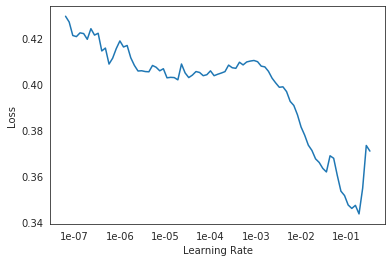

In [212]:
learn.recorder.plot()

In [225]:
learn.fit_one_cycle(div_factor=100,max_lr=5e-3,cyc_len=10)

epoch     train_loss  valid_loss  accuracy  time    
0         0.018826    1.397614    0.786333  00:09     
1         0.018146    1.498545    0.786333  00:09     
2         0.021700    1.469156    0.785867  00:09     
3         0.012701    2.094084    0.786333  00:09     
4         0.014599    2.059988    0.786133  00:09     
5         0.011543    2.081101    0.786133  00:09     
6         0.007831    2.154481    0.786267  00:09     
7         0.005234    2.265994    0.786133  00:09     
8         0.004927    2.216839    0.786000  00:09     
9         0.003795    2.097313    0.785800  00:09     


In [214]:
learn.predict(df.iloc[3])

(Category 0, tensor(0), tensor([9.9929e-01, 7.0689e-04]))

In [78]:
# learn methods
# 'add_time', 'apply_dropout', 'backward', 'bn_wd', 'callback_fns', 'callbacks', 
# 'clip_grad', 'create_opt', 'data', 'destroy', 'dl', 'export', 
# 'fit', 'fit_fc', 'fit_one_cycle', 'freeze', 'freeze_to', 'get_preds', 
# 'init', 'interpret', 'layer_groups', 'load', 'loss_func', 
# 'lr_find', 'lr_finder', 'lr_range', 'metrics', 'mixup', 
# 'model', 'model_dir', 'one_cycle_scheduler', 'opt', 'opt_func', 
# 'path', 'pred_batch', 'predict', 'predict_with_mc_dropout', 
# 'purge', 'recorder', 'save', 'show_results', 'silent', 'split', 
# 'summary', 'to_fp16', 'to_fp32', 'train_bn', 'true_wd', 'unfreeze', 
# 'validate', 'wd'

In [215]:
learn.show_results()


addr_state,application_type,debt_settlement_flag,disbursement_method,earliest_cr_line,grade,home_ownership,id,initial_list_status,int_rate,issue_d,purpose,pymnt_plan,sec_app_earliest_cr_line,sub_grade,term,verification_status,zip_code,emp_bin,acc_open_past_24mths_na,all_util_na,acc_open_past_24mths,all_util,target,prediction
CA,Individual,N,#na#,2004-01-01 00:00:00,B,RENT,#na#,f,11.31%,2018-12-01 00:00:00,credit_card,n,#na#,B3,36 months,Not Verified,928xx,6,False,False,-0.7872,-0.9580,0,0
IL,Individual,N,#na#,2010-01-01 00:00:00,A,RENT,#na#,f,6.46%,2019-01-01 00:00:00,other,n,#na#,A1,36 months,Not Verified,302xx,10,False,False,-0.1658,-1.8219,0,0
OR,Individual,N,#na#,2004-09-01 00:00:00,A,MORTGAGE,#na#,w,6.83%,2018-06-01 00:00:00,credit_card,n,#na#,A3,36 months,Source Verified,970xx,10,False,False,-0.4765,1.1539,1,0
CA,Individual,N,#na#,2000-07-01 00:00:00,A,RENT,#na#,w,8.46%,2018-09-01 00:00:00,credit_card,n,#na#,A5,36 months,Not Verified,908xx,10,False,False,-1.0979,-0.8140,0,0
PA,Individual,N,Cash,2007-10-01 00:00:00,A,RENT,#na#,f,5.32%,2017-07-01 00:00:00,credit_card,n,#na#,A1,36 months,Not Verified,191xx,6,False,False,-0.7872,-0.5740,0,0


In [216]:
interp = learn.interpret()


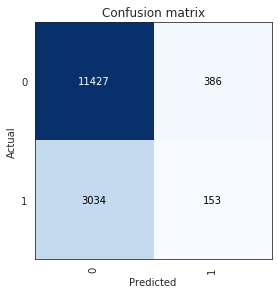

In [219]:
# interp.confusion_matrix()
interp.plot_confusion_matrix()
#interp.plot_tab_top_losses(10)

In [218]:
interp.losses

tensor([0.0049, 0.0100, 1.2179,  ..., 0.2313, 0.1568, 0.0880])

### Train / Test set creation

One of the key points in any machine learning workflow is the **partitioning** of the data set into **train** and **test** sets.  The key idea here is that a model is built using the training data, and evaluated using the test data.  

There are more nuances to how you partition data into train/test sets, but for purposes of this lab we will omit these finer points.

In [ ]:
%load_ext autoreload
%autoreload 2
from lc_utils import *

In [ ]:
# Instantiate lendingclub_ml object that will hold our test, and contain methods used for testing.
# Implementation done like this to ease the burden on users for keeping track of train/test sets for different
# models we are going to build.

my_analysis = lendingclub_ml(loan_df)

In [ ]:
# Create a train / test split of your data set.  Paramter is test set size percentage 
# Returns data in the form of dataframes

my_analysis.create_train_test(test_size=0.4)

### Dimension Reduction
For this modeling exercise we will perform a couple of tasks, **dimension reduction** and **classification** as shown in the following diagram.

<img src="https://github.com/dustinvanstee/random-public-files/raw/master/techu-modeling-workflow.png" width="800" height="500" align="middle"/>

**Dimension Reduction** is useful in scenarios when you have a large number of columns and you would like to reduce that down to a compressed representation .  In this lab we will try 2 methods of dimension reduction.  It will be your choice to decide which method you want to use for the classification part of the lab ! (you could even decice to bypass this if you want ...)


### Dimension Reduction - PCA

<img src="https://github.com/dustinvanstee/random-public-files/raw/master/techu-pca.png"  width="200" height="125" align="middle"/>

Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. The number of principal components is less than or equal to the number of original variables.

A simple way to think about PCA is that it helps compress the data in a lossy representation of the original dataset.

This will also be used to help us visualize the data as you will see below

In [ ]:
# Dimension Reduction using PCA
my_analysis.build_pca_model(n_components=20)

In the chart above, you can see that we get ok results from PCA.  Using the first 20 principal components, we can account for ~50% of the variance described in the dataset.  **Feel free to change the number of principal components above to see if adding more helps with explained variance.**

### Dimension Reduction - AutoEncoder

<img src="https://github.com/dustinvanstee/random-public-files/raw/master/techu-ae.png"  width="600" height="375" align="middle"/>

An autoencoder is another method that can be used for dimension reduction.  An autoencoder is a **neural network** that tries to reproduce itself given the constraint that it will lose information in the bottleneck layer.  Based on this, its again a lossy representation.  One key difference between autoencoders and PCA is that an autoencoder can find non linear relationships between variables that PCA could not detect.

In [ ]:
# This will build and run your auto-encoder 
# feel free to adjust 
# ae_layers -> needs to be an odd number of layers, and symmetric 
# Regularization -> controls overfitting
# epochs -> number of times to loop thru training set

my_analysis.build_ae_model(ae_layers=[100,25,6,25,100], regularization=0.001, epochs=1)

**Class Contest**  lets see who can find the best settings for the neural network to minimize loss!  Just yell out your results and instructor will add to the leaderboard!

# Now update our test dataframe with new columns that are predicted by our PCA and Autoencoder models.  

Here we will now take the models that we built and pass our test data set through the models.   By doing this, we will have reduced the number features in our data set by a significant amount (~177 colums => ~5-20 columns!)  .  

In this step we will add new columns to our test/train data frames for both our PCA model and our autoencoder model.  Don't worry about the details of this step, its just required for some followon visualization, and training steps ahead. 



In [ ]:
my_analysis.update_train_test_df()

### Cool Visualizations using our dimension reduction columns

Next we will plot a few scatterplot grids based on our pricipal component and autoencoder representations of the data

We will color each data point using this key
```
Green -> Fully paid or current loan
Red   -> Loan in default
```

In [ ]:
# This will take a minute or so ...
my_analysis.visualize_dimred_results(mode='pca')

In [ ]:
# This will take a minute or so ...
my_analysis.visualize_dimred_results(mode='ae')

If you can discern a pattern between the red / green dots, its likely we can use a classifier to automatically seperate them! We'll see that in a few more sections

### Heatmap commentary
Using a heatmap can be another good visualization tool.  You can use this to get a sense of how the data correlates to each other.  In the code below, play with the **sortColumn** input .  In the example below we are sorting by principal component 0, which has the most information encoded in that column.  See if you can find out what PC0 might be composed of.  Try it for PC1, or AE0, AE1...

Pro tip, to get the most out of a heatmap, all the data needs to be normalized on a common 0 -> 1 scale so that the coloring of the columns works out ..


In [ ]:
# This will take a minute or so ...
bob_heatmap_lc(my_analysis.test_df,sortColumn='PC0',add_corr=1)

The resolution is quite small, but try to find columns that go from solid red on bottom to black on top. That would be an indication of high correclation to your sort column

# Modelling - Lending Club Default Prediction

<img src="https://github.com/dustinvanstee/random-public-files/raw/master/techu-modeling-traintest.png"  width="600" height="375" align="middle"/>

Here we will build a classifier to predict if loan will fail or not.  We will us a 
** Deep Learning Classifier **  .  You will have 3 options for data sources, 
* the raw data
* PCA dimension reduction features
* Autoencoder features

To evaluate our model, we will use a simple contingency table (showing true/false positve/negative).  However, this is a fairly simplistic method.  Better method that data scientists use are F1 score, and PR/ROC curves but thats beyond the scope of this lab.

Step 1 here is to set our baseline result.  In this example, we are dealing with a **skewed** dataset.  This means, on average, most people will not default, and they pay their loan off.  If you built a classifier that just predicted no default, you would be right most of the time.  Lets see the stats from our dataset below....

In [ ]:
# Set our baseline
my_analysis.train_df['default'].describe()


As you can see, **only ~12.8% of the applicants default**.  Any classifier we build must be better than this, or we aren't doing a very good job ;)

In [ ]:
# modes
# pca           : principal components only
# ae            : autoencoder components only
# raw           : all the data non reduced
# raw_no_grades : all the data non reduced except the grade info provided by lending club

mode = 'raw' # ae , raw, raw_no_grades

if(mode == 'pca') :
            x_cols = [x for x in my_analysis.train_df.columns if 'PC' in x]
elif(mode == 'ae') :
            x_cols = [x for x in my_analysis.train_df.columns if 'AE' in x]
elif(mode == 'raw') :
            x_cols = [x for x in my_analysis.train_df.columns if 'AE' not in x and 'PC' not in x]
elif(mode == 'raw_no_grades') :
            x_cols = [x for x in my_analysis.train_df.columns if 'AE' not in x and 'PC' not in x]
            import re
            x_cols = [x for x in x_cols if not re.match('^[ABCDEFG]',x)]

#print(x_cols)
# explode here ..
# my_analysis.build_evaluate_dl_classifier(x_cols, epochs=25,batch_size=32,regularization=0.001)
my_analysis.X_train_scaled.head(20)

In [ ]:
my_analysis.X_train_scaled.to_parquet("X_train_scaled")
pd.DataFrame(my_analysis.Y_train).to_parquet("Y_train")
my_analysis.X_test_scaled.to_parquet("X_test_scaled")
pd.DataFrame(my_analysis.Y_test).to_parquet("Y_test")


## SnapML Training

In [ ]:
# Load Datasets (pre-saved)
X_train = pd.read_parquet("X_train_scaled").to_numpy()
y_train = pd.read_parquet("Y_train").to_numpy()
X_test = pd.read_parquet("X_test_scaled").to_numpy()
y_test = pd.read_parquet("Y_test").to_numpy()

# Setup Datasets
# X_train = my_analysis.X_train_scaled.to_numpy()
# y_train = my_analysis.Y_train.to_numpy()
# X_test = my_analysis.X_test_scaled.to_numpy()
# y_test = my_analysis.Y_test.to_numpy()


In [ ]:
# Import the LogisticRegression from snap.ml
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score
from pai4sk import LogisticRegression
snapml_lr = LogisticRegression(use_gpu = True, device_ids = [0],
                        num_threads = 256, 
                        fit_intercept = True, regularizer = 10)

In [ ]:
# Training
t0 = time.time()
snapml_lr.fit(X_train, y_train)
print("[snap.ml] Training time (s):  {0:.2f}".format(time.time()-t0))

In [ ]:
# Evaluate accuracy on test set
snapml_prediction = snapml_lr.predict(X_test)
print('snap ml accuracy score = ', accuracy_score(y_test, snapml_prediction))

## SkLearn Training

In [ ]:
# Import
from sklearn.linear_model import LogisticRegression
sklearn_lr = LogisticRegression(verbose=1)

In [ ]:
# TRAIN
t0 = time.time()
sklearn_lr.fit(X_train, y_train)
print("[sklearn] Training time (s):  {0:.5f}".format(time.time()-t0))


In [ ]:
sklearn_prediction = sklearn_lr.predict(X_test)
print('sklearn ml accuracy score = ', accuracy_score(y_test, sklearn_prediction))

### Credits 
* Bob Chesebrough - IBM CSSC Data Scientist
* Catherine Cao - IBM FSS Data Scientist
* [Hands on Machine Learning - Geron] (https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/)

### More Learning
* Coursera Deeplearning.ai  (Ng)
* Coursera Machine Learning (Ng)
